<a href="https://colab.research.google.com/github/shekarroy15/Our-Capstone-Project/blob/main/Final_Resnet50_withPredictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import tensorflow as tf

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, model_from_json
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import pickle
import multiprocessing

import seaborn as sns
import os
import scipy.io

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !unzip /content/drive/MyDrive/CAPSTONE_PROJECT/Annotations.zip > /dev/null
!unzip /content/drive/MyDrive/CAPSTONE_PROJECT/Car+Images.zip > /dev/null

In [ ]:
batch_size = 64 # try 128 and see if colab survives the OOM

train_datagen = ImageDataGenerator(
                  rescale = 1./255.,
                  rotation_range = 25, 
                  width_shift_range = 0.2, 
                  height_shift_range = 0.2, 
                  shear_range = 0.2, 
                  zoom_range = 0.2, 
                  horizontal_flip = True,
                  fill_mode='constant',
                  validation_split=0.2) 

train_generator = train_datagen.flow_from_directory(
        '/content/Car Images/Train Images',  
        target_size=(224, 224),  
        batch_size=batch_size,
        # interpolation='bicubic',
        subset='training',
        class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
        '/content/Car Images/Test Images',
        target_size=(224, 224),
        batch_size=batch_size,
        # interpolation='bicubic',
        subset='validation',
        class_mode='categorical')

Number_Of_Training_Images = train_generator.classes.shape[0]
steps_per_epoch = Number_Of_Training_Images/batch_size

Found 6598 images belonging to 196 classes.
Found 1524 images belonging to 196 classes.


In [ ]:
!pip install wandb 
!wandb login

In [ ]:
import wandb
from wandb.keras import WandbCallback

wandb.init(project="test-project", entity="capstone7")

In [ ]:
model = Sequential()
input_shape = (224,224,3)

pretrained_model = ResNet50(
                   include_top=False,
                   input_shape=input_shape,
                   pooling='avg',
                   classes=196,
                   weights='imagenet')
                   
# We unfreeze the top 20 layers while leaving BatchNorm layers frozen
for layer in pretrained_model.layers[-20:]:
      if isinstance(layer, BatchNormalization):
        layer.trainable = False
      else:
        layer.trainable = True   


model.add(pretrained_model)
#model.add(Flatten())
#model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(2048, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(196, activation='softmax'))

model.summary()


94781440/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 2048)              4196352   
                                                                 
 dense_1 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 dense_3 (Dense)             (None, 196)               100548    
                                                         

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-5, epsilon=1e-08), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-2, patience=3, mode='auto')
checkpointer = ModelCheckpoint(filepath='saved_models/best_resnet.hdf5', verbose=1, save_best_only=True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.1, min_lr=0.0001)

history = model.fit(train_generator, epochs = 30, 
                    validation_data = validation_generator,
                    steps_per_epoch = steps_per_epoch,
                    callbacks=[learning_rate_reduction, checkpointer],
                    workers=multiprocessing.cpu_count())

Epoch 1/30
104/103 [==============================] - ETA: -1s - loss: 0.8704 - accuracy: 0.7499
Epoch 1: val_loss improved from inf to 1.87577, saving model to saved_models/best_resnet.hdf5
103/103 [==============================] - 202s 2s/step - loss: 0.8704 - accuracy: 0.7499 - val_loss: 1.8758 - val_accuracy: 0.5525 - lr: 1.0000e-05
Epoch 2/30
104/103 [==============================] - ETA: -1s - loss: 0.7908 - accuracy: 0.7734
Epoch 2: val_loss improved from 1.87577 to 1.79331, saving model to saved_models/best_resnet.hdf5
103/103 [==============================] - 200s 2s/step - loss: 0.7908 - accuracy: 0.7734 - val_loss: 1.7933 - val_accuracy: 0.5538 - lr: 1.0000e-05
Epoch 3/30
104/103 [==============================] - ETA: -1s - loss: 0.7261 - accuracy: 0.7871
Epoch 3: val_loss did not improve from 1.79331
103/103 [==============================] - 198s 2s/step - loss: 0.7261 - accuracy: 0.7871 - val_loss: 1.8194 - val_accuracy: 0.5741 - lr: 1.0000e-05
Epoch 4/30
104/103 [===

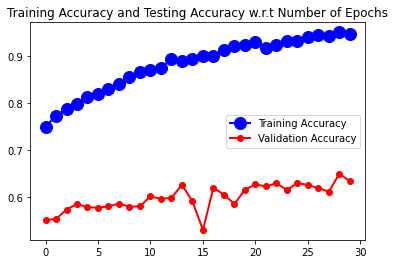

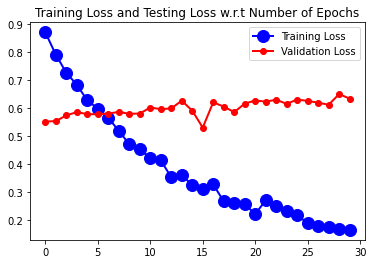

In [ ]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
No_Of_Epochs = range(30)

plt.plot(No_Of_Epochs, train_acc, marker = 'o', color = 'blue', markersize = 12, linewidth = 2, label = 'Training Accuracy')
plt.plot(No_Of_Epochs, val_acc, marker = '.', color = 'red', markersize = 12,linewidth = 2, label = 'Validation Accuracy')

plt.title('Training Accuracy and Testing Accuracy w.r.t Number of Epochs')
plt.legend()
plt.figure()

plt.plot(No_Of_Epochs, train_loss, marker = 'o', color = 'blue', markersize = 12, linewidth = 2, label = 'Training Loss')
plt.plot(No_Of_Epochs, val_acc, marker = '.', color = 'red', markersize = 12, linewidth = 2, label = 'Validation Loss')

plt.title('Training Loss and Testing Loss w.r.t Number of Epochs')
plt.legend()

plt.show()



In [ ]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/best_resnet.hdf5')

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        '/content/Car Images/Test Images',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=False)
pred = loaded_model.predict(test_generator, steps=len(test_generator), verbose=1)
# Get classes by max element in np (as a list)
classes = list(np.argmax(pred, axis=1))
# Get filenames (set shuffle=false in generator is important)
filenames = test_generator.filenames

Found 8041 images belonging to 196 classes.
252/252 [==============================] - 105s 373ms/step


In [ ]:
labels = (test_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in classes]

In [ ]:
results=pd.DataFrame({"Filename":filenames,"Predictions":predictions})

In [ ]:
results.head(15)

,Filename,Predictions
0,AM General Hummer SUV 2000/00076.jpg,AM General Hummer SUV 2000
1,AM General Hummer SUV 2000/00457.jpg,AM General Hummer SUV 2000
2,AM General Hummer SUV 2000/00684.jpg,AM General Hummer SUV 2000
3,AM General Hummer SUV 2000/01117.jpg,AM General Hummer SUV 2000
4,AM General Hummer SUV 2000/01167.jpg,AM General Hummer SUV 2000
5,AM General Hummer SUV 2000/01199.jpg,HUMMER H2 SUT Crew Cab 2009
6,AM General Hummer SUV 2000/01226.jpg,AM General Hummer SUV 2000
7,AM General Hummer SUV 2000/01461.jpg,AM General Hummer SUV 2000
8,AM General Hummer SUV 2000/01518.jpg,AM General Hummer SUV 2000
9,AM General Hummer SUV 2000/01538.jpg,AM General Hummer SUV 2000


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(test_generator.classes, classes, target_names=test_generator.class_indices))

                                                        precision    recall  f1-score   support

                            AM General Hummer SUV 2000       0.89      0.89      0.89        44
                             Acura Integra Type R 2001       0.77      0.61      0.68        44
                                   Acura RL Sedan 2012       0.45      0.41      0.43        32
                                   Acura TL Sedan 2012       0.61      0.84      0.71        43
                                  Acura TL Type-S 2008       0.66      0.60      0.62        42
                                  Acura TSX Sedan 2012       0.71      0.50      0.59        40
                              Acura ZDX Hatchback 2012       0.62      0.33      0.43        39
              Aston Martin V8 Vantage Convertible 2012       0.55      0.40      0.46        45
                    Aston Martin V8 Vantage Coupe 2012       0.58      0.44      0.50        41
                  Aston Martin Virage C

# Pickling the model for future use

In [26]:
model_json = loaded_model.to_json()
with open("/content/drive/MyDrive/best_resnet.hdf5", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
loaded_model.save_weights("/content/drive/MyDrive/best_resnet.hdf5")
print("Saved model to disk")

Saved model to disk
